In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.power as smp
from resultsHelper import cohen_d, perform_shapiro_test

In [54]:
datasets = ['Adult', 'Compas', 'Law-Gender', 'Law-Race']
#metrics = ['nDCG', 'rND', 'GPA']
metrics = ['AUC', 'Main Accuracy', 'GPA']

In [8]:
df = pd.read_csv(f'../Results/DebiasClassifier/Law-Gender/T-Test/SGD/results.csv')
#df = df[df['Schedule'] == '[1; 1]']
print(np.median(df['nDCG']))
print(np.median(df['AUC']))
print(np.median(df['rND']))
print(np.median(df['GPA']))

0.9793811698429011
0.9983992878307909
0.06202664459969405
0.01713540138676245


In [6]:
df = pd.read_csv(f'../Results/DirectRankerAdv/Adult/T-Test/Run03/results.csv')
df['Main Schedule'] = df.apply(lambda x: int(x['Schedule'][1]), axis=1)
df['Adv Schedule'] = df.apply(lambda x: int(x['Schedule'][4]), axis=1)
greater_main_df = df[df['Main Schedule'] > df['Adv Schedule']]
greater_adv_df = df[df['Adv Schedule'] > df['Main Schedule']]
exact_df = df[df['Adv Schedule'] == df['Main Schedule']]
print(np.median(greater_main_df['nDCG']))
print(np.median(greater_adv_df['rND']))

0.893802672624588
0.15362422892809105


# Check if the data follows a normal distribution with the Shapiro Wilks test

In [55]:
from scipy.stats import shapiro
total_normal = 0
total_not_normal = 0
print(f'Measuring on:', *metrics, '\n')
for dataset in datasets:

    #df = pd.read_csv(f'../Results/DirectRankerAdv/{dataset}/T-Test/Run02/results.csv')
    df = pd.read_csv(f'../Results/DebiasClassifier/{dataset}/T-Test/SGD/results.csv')
    
    df['Main Schedule'] = df.apply(lambda x: int(x['Schedule'][1]), axis=1)
    df['Adv Schedule'] = df.apply(lambda x: int(x['Schedule'][4]), axis=1)
    
    greater_main_df = df[df['Main Schedule'] > df['Adv Schedule']]
    greater_adv_df = df[df['Adv Schedule'] > df['Main Schedule']]
    exact_df = df[df['Adv Schedule'] == df['Main Schedule']]

    count_normal = 0
    count_not_normal = 0
    for string_group ,group in {'x > y': greater_main_df, 'x < y': greater_adv_df, 'x == y': exact_df}.items():
        p_values = []
        normal = []

        for i, metric in enumerate(metrics):         
            stat, p_value = shapiro(group[metric])
            p_values.append(p_value)
            if p_value < 0.5:
                count_not_normal += 1
            else:
                count_normal += 1

    total_normal += count_normal
    total_not_normal += count_not_normal

    print(f'{dataset} - normal: {count_normal}  not normal: {count_not_normal}')

print(f'\nTotal normal: {total_normal}  total not normal: {total_not_normal}')
        
    

Measuring on: AUC Main Accuracy GPA 

Adult - normal: 6  not normal: 3
Compas - normal: 7  not normal: 2
Law-Gender - normal: 0  not normal: 9
Law-Race - normal: 0  not normal: 9

Total normal: 13  total not normal: 23


# Test data on similar distributions

In [56]:
import numpy as np
import scipy.stats as stats
total_similar = 0
total_not_similar = 0
add_not_similar = lambda p: 1 if p < 0.05 else 0
add_similar = lambda p: 1 if p > 0.05 else 0
print(f'Measuring on:', *metrics, '\n')

for dataset in datasets:

    #df = pd.read_csv(f'../Results/DirectRankerAdv/{dataset}/T-Test/Run02/results.csv')
    df = pd.read_csv(f'../Results/DebiasClassifier/{dataset}/T-Test/SGD/results.csv')
    df['Main Schedule'] = df.apply(lambda x: int(x['Schedule'][1]), axis=1)
    df['Adv Schedule'] = df.apply(lambda x: int(x['Schedule'][4]), axis=1)

    greater_main_df = df[df['Main Schedule'] > df['Adv Schedule']]
    greater_adv_df = df[df['Adv Schedule'] > df['Main Schedule']]
    exact_df = df[df['Adv Schedule'] == df['Main Schedule']]

    count_similar = 0
    count_not_similar = 0
    
    for metric in metrics:
        group1 = greater_main_df[metric]
        group2 = greater_adv_df[metric]
        group3 = exact_df[metric]

        ks_statistic, p_value_1 = stats.ks_2samp(group1, group2)
        #count_similar += add_similar(p_value)
        #count_not_similar += add_not_similar(p_value)

        ks_statistic, p_value_2 = stats.ks_2samp(group1, group3)
        #count_similar += add_similar(p_value)
        #count_not_similar += add_not_similar(p_value)

        ks_statistic, p_value_3 = stats.ks_2samp(group2, group3)
        #count_similar += add_similar(p_value)
        #count_not_similar += add_not_similar(p_value)
        if p_value_1 < 0.05 and p_value_2 < 0.05 and p_value_3 < 0.05:
            count_similar += 1
        else:
            count_not_similar += 1

    total_similar += count_similar
    total_not_similar += count_not_similar
    
    print(f'{dataset} - similar: {count_similar}  not similar: {count_not_similar}')
    
print(f'\nTotal similar: {total_similar}  total not similar: {total_not_similar}')

Measuring on: AUC Main Accuracy GPA 

Adult - similar: 1  not similar: 2
Compas - similar: 0  not similar: 3
Law-Gender - similar: 0  not similar: 3
Law-Race - similar: 0  not similar: 3

Total similar: 1  total not similar: 11


# Mann Whitney U Test
### if data is not normal but have similar distribution

In [49]:
total_significant = 0
total_non_significant = 0
print(f'Measuring on:', *metrics, '\n')
for dataset in datasets:

    #df = pd.read_csv(f'../Results/DirectRankerAdv/{dataset}/T-Test/Run02/results.csv')
    df = pd.read_csv(f'../Results/DebiasClassifier/{dataset}/T-Test/SGD/results.csv')
    df['Main Schedule'] = df.apply(lambda x: int(x['Schedule'][1]), axis=1)
    df['Adv Schedule'] = df.apply(lambda x: int(x['Schedule'][4]), axis=1)
    
    greater_main_df = df[df['Main Schedule'] > df['Adv Schedule']]
    greater_adv_df = df[df['Adv Schedule'] > df['Main Schedule']]
    exact_df = df[df['Adv Schedule'] == df['Main Schedule']]

    num_significant = 0
    num_non_significant = 0
    
    for i, metric in enumerate(metrics):
        p_values = []
        p_values.append(stats.mannwhitneyu(greater_adv_df[metric], greater_main_df[metric])[1])
        p_values.append(stats.mannwhitneyu(greater_adv_df[metric], exact_df[metric])[1])
        p_values.append(stats.mannwhitneyu(exact_df[metric], greater_main_df[metric])[1])
        for p_value in p_values:
            if p_value < 0.5:
                num_significant += 1
            else:
                num_non_significant += 1

    total_significant += num_significant
    total_non_significant += num_non_significant

    print(f'{dataset} - Significant: {num_significant}  non Significant: {num_non_significant}')

print(f'\nTotal Significant: {total_significant}  Total non Significant: {total_non_significant}')



Measuring on: AUC Main Accuracy Sensitive Accuracy GPA 

Law-Gender - Significant: 6  non Significant: 6
Law-Race - Significant: 7  non Significant: 5
Adult - Significant: 11  non Significant: 1
Compas - Significant: 10  non Significant: 2

Total Significant: 34  Total non Significant: 14


# Kruskal Wallis Test
### If data is not normal and distribution aren't similar

In [57]:
def remove_outliers(series):
    # Assuming 'series' is your pandas Series
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # Define the acceptable range (this can be adjusted based on your preference)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    filtered_series = series[(series >= lower_bound) & (series <= upper_bound)]
    return filtered_series

In [58]:
total_significant = 0
total_non_significant = 0
print(f'Measuring on:', *metrics, '\n')
for dataset in datasets:

    count_significant = 0
    count_non_significant = 0
    
    for metric in metrics:
        #df = pd.read_csv(f'../Results/DirectRankerAdv/{dataset}/T-Test/Run02/results.csv')
        df = pd.read_csv(f'../Results/DebiasClassifier/{dataset}/T-Test/SGD/results.csv')

        df['Main Schedule'] = df.apply(lambda x: int(x['Schedule'][1]), axis=1)
        df['Adv Schedule'] = df.apply(lambda x: int(x['Schedule'][4]), axis=1)
    
        greater_main_df = df[df['Main Schedule'] > df['Adv Schedule']]
        greater_adv_df = df[df['Adv Schedule'] > df['Main Schedule']]
        exact_df = df[df['Adv Schedule'] == df['Main Schedule']]

        group1 = greater_main_df[metric]
        group2 = greater_adv_df[metric]
        group3 = exact_df[metric]

        group1 = remove_outliers(greater_main_df[metric])
        group2 = remove_outliers(greater_adv_df[metric])
        group3 = remove_outliers(exact_df[metric])

        # Perform Kruskal-Wallis Test
        kruskal_result = stats.kruskal(group1, group2, group3)
        if kruskal_result.pvalue < 0.05:
            count_significant += 1
        else:
            count_non_significant += 1
            print(f'Not significant on: {dataset}, {metric}')

    total_significant += count_significant
    total_non_significant += count_non_significant

    print(f'{dataset} - significant: {count_significant}  not significant: {count_non_significant}')
    
print(f'\nTotal significant: {total_significant}  total non significant: {total_non_significant}')


Measuring on: AUC Main Accuracy GPA 

Adult - significant: 3  not significant: 0
Not significant on: Compas, Main Accuracy
Not significant on: Compas, GPA
Compas - significant: 1  not significant: 2
Not significant on: Law-Gender, AUC
Not significant on: Law-Gender, Main Accuracy
Not significant on: Law-Gender, GPA
Law-Gender - significant: 0  not significant: 3
Not significant on: Law-Race, AUC
Not significant on: Law-Race, Main Accuracy
Law-Race - significant: 1  not significant: 2

Total significant: 5  total non significant: 7


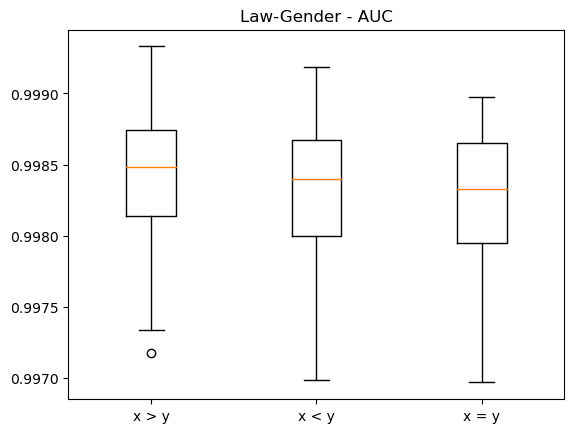

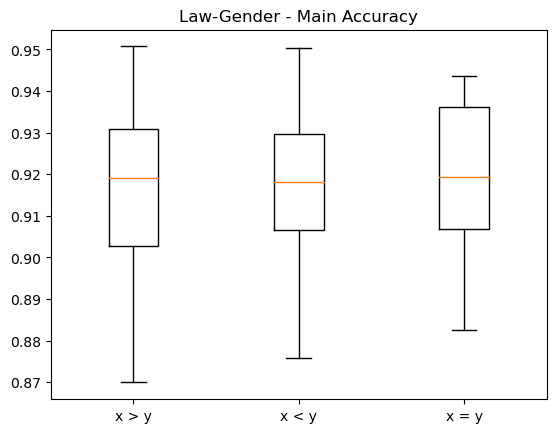

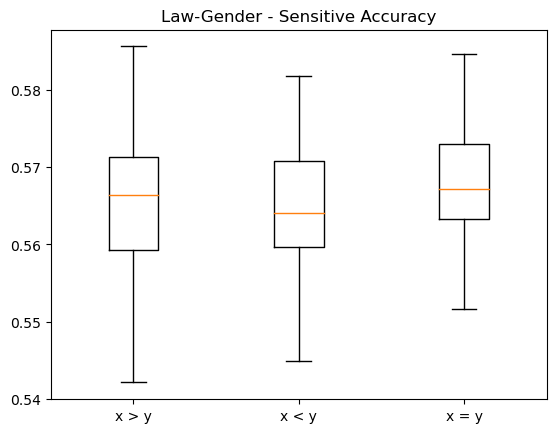

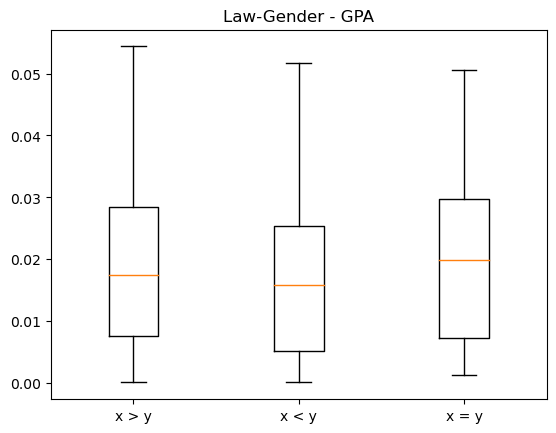

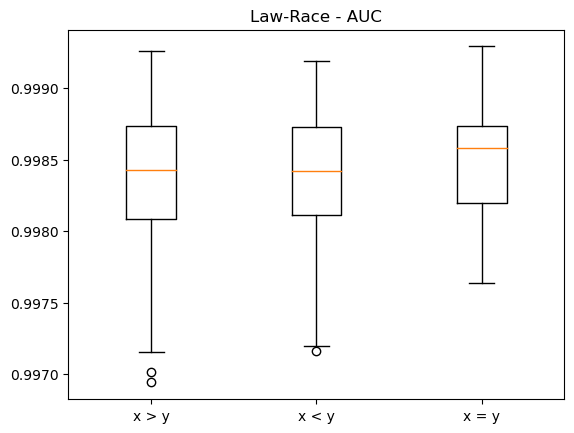

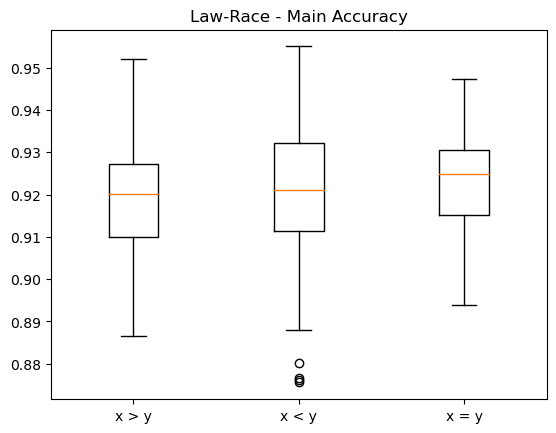

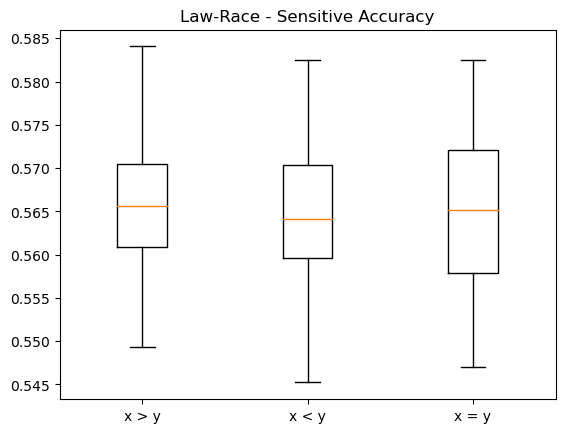

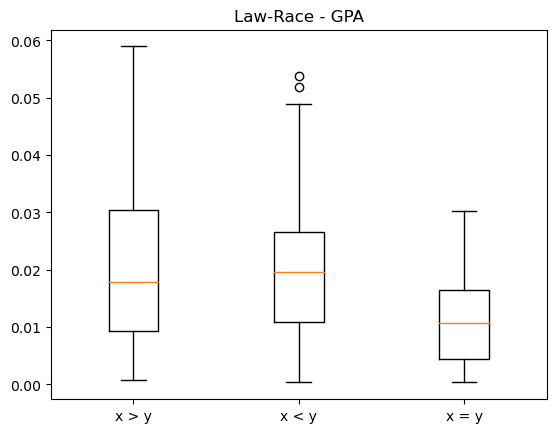

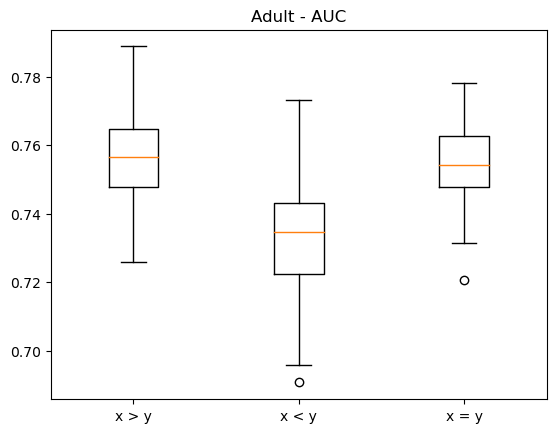

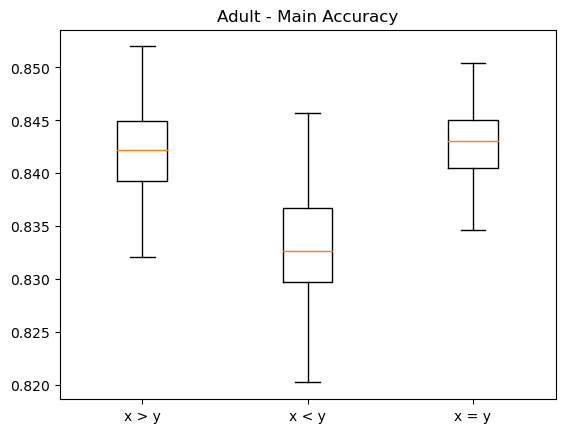

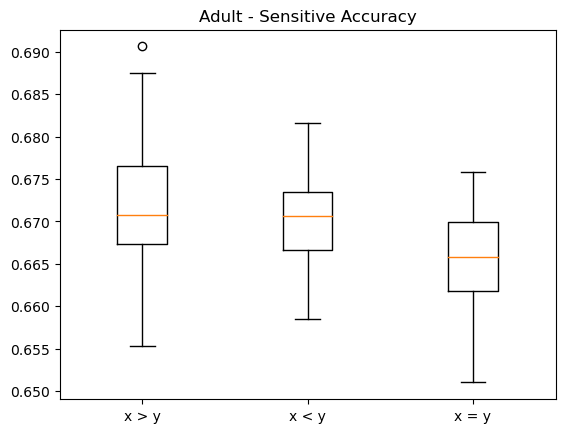

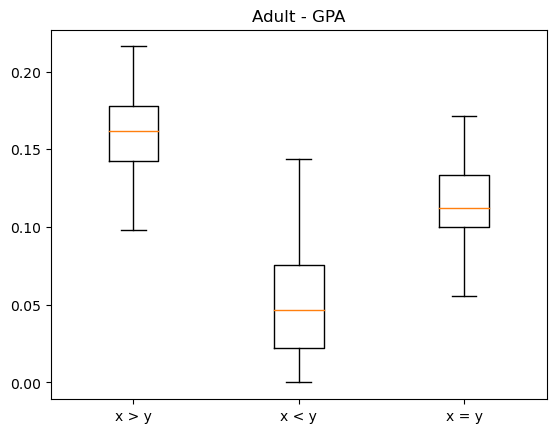

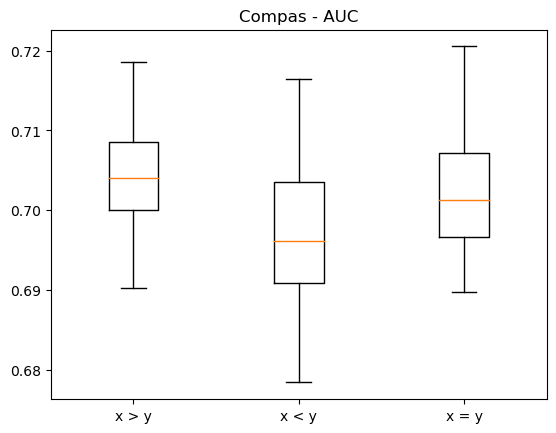

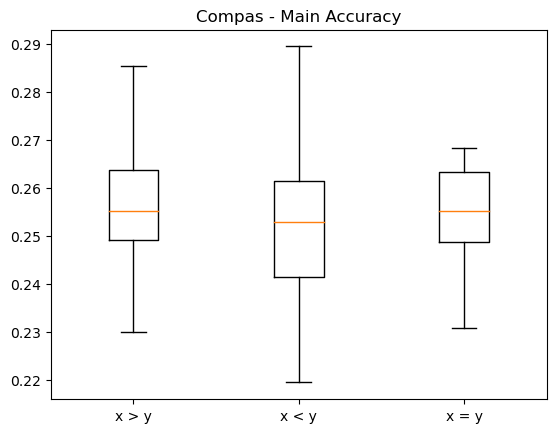

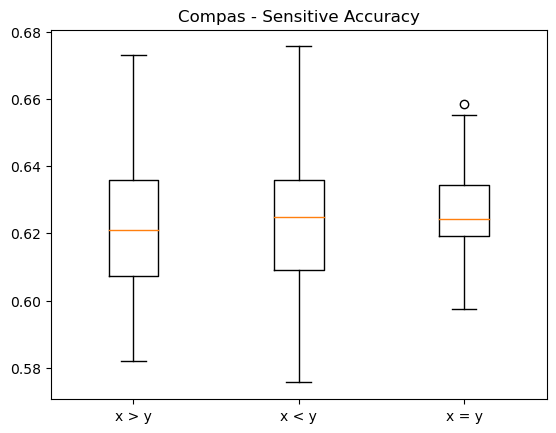

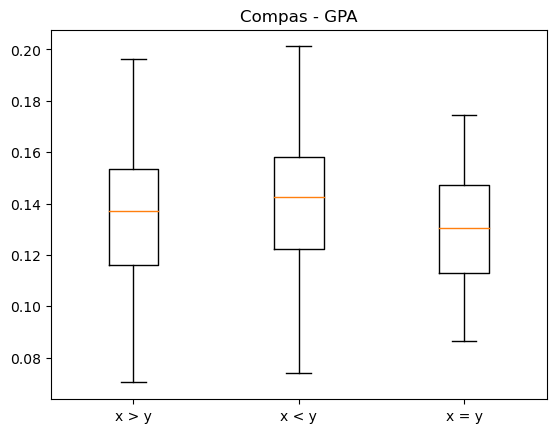

In [53]:
import matplotlib.pyplot as plt
metrics = ['AUC', 'Main Accuracy','Sensitive Accuracy', 'GPA']
datasets=['Law-Gender', 'Law-Race', 'Adult', 'Compas']
for dataset in datasets:

    #df = pd.read_csv(f'../Results/DirectRankerAdv/{dataset}/T-Test/Run02/results.csv')
    df = pd.read_csv(f'../Results/DebiasClassifier/{dataset}/T-Test/SGD/results.csv')

    metric = 'rND'
    df['Main Schedule'] = df.apply(lambda x: int(x['Schedule'][1]), axis=1)
    df['Adv Schedule'] = df.apply(lambda x: int(x['Schedule'][4]), axis=1)

    greater_main_df = df[df['Main Schedule'] > df['Adv Schedule']]
    greater_adv_df = df[df['Adv Schedule'] > df['Main Schedule']]
    exact_df = df[df['Adv Schedule'] == df['Main Schedule']]

    for metric in metrics:
        group1 = greater_main_df[metric]
        group2 = greater_adv_df[metric]
        group3 = exact_df[metric]
        group1 = remove_outliers(greater_main_df[metric])
        group2 = remove_outliers(greater_adv_df[metric])
        group3 = remove_outliers(exact_df[metric])
        data_to_plot = [group1, group2, group3]
        fig, ax = plt.subplots()

        # Create the boxplot
        ax.boxplot(data_to_plot)

        # Set x-axis labels (optional)
        ax.set_xticklabels(['x > y', 'x < y', 'x = y'])
        ax.set_title(f'{dataset} - {metric}')
        #fig.savefig(f'./DebiasClassifier/Distributions/{dataset}_{metric}.png', dpi=1200)



In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

dataset='Law-Gender'
metrics = ['nDCG', 'rND', 'GPA']
model = 'DirectRankerAdv'
#df = pd.read_csv(f'../Results/{model}/{dataset}/Custom/results.csv')
df3 = pd.read_csv(f'../Results/{model}/{dataset}/Custom/results2.csv')
df2 = pd.read_csv(f'../Results/{model}/{dataset}/T-Test/Run02/results.csv')

df2['Main Schedule'] = df2.apply(lambda x: int(x['Schedule'][1]), axis=1)
df2['Adv Schedule'] = df2.apply(lambda x: int(x['Schedule'][4]), axis=1)

greater_main_df = df2[df2['Main Schedule'] > df2['Adv Schedule']]
greater_adv_df = df2[df2['Adv Schedule'] > df2['Main Schedule']]
exact_df = df2[df2['Adv Schedule' ] == df2['Main Schedule']]
greater_main_df['1-rND'] = greater_main_df.apply(lambda x: 1-x['rND'], axis=1)
greater_adv_df['1-rND'] = greater_adv_df.apply(lambda x: 1-x['rND'], axis=1)
exact_df['1-rND'] = exact_df.apply(lambda x: 1-x['rND'], axis=1)
df3['1-rND'] = df3.apply(lambda x: 1-x['rND'], axis=1)
fig, ax = plt.subplots(1)

accs = [np.median(greater_main_df['nDCG']), np.median(greater_adv_df['nDCG']), np.median(exact_df['nDCG']), np.median(df3['nDCG'])]
rnds = [np.median(greater_main_df['1-rND']), np.median(greater_adv_df['1-rND']), np.median(exact_df['1-rND']), np.median(df3['1-rND'])]
accs = [greater_main_df['nDCG'], greater_adv_df['nDCG'], exact_df['nDCG'], df3['nDCG']]
rnds = [greater_main_df['1-rND'], greater_adv_df['1-rND'], exact_df['1-rND'], df3['1-rND']]
#ax.boxplot(data_to_plot)
for i in range(len(accs)):
    ax.scatter(accs[i], rnds[i])
ax.legend(['x > y', 'x < y', 'x = y', 'Dynamic'])
ax.set_title(f'{dataset}')
ax.set_xlabel('nDCG@500')
ax.set_ylabel('1-rND')
#fig.savefig(f'../InterpretingResults/DebiasClassifier/ComparingClassifiers/{dataset}.png', dpi=1200)


FileNotFoundError: [Errno 2] No such file or directory: '../Results/DirectRankerAdv/Law-Gender/Custom/results2.csv'